# Inner Speech EEG Dataset Access

This notebook demonstrates how to access and load the preprocessed EEG data from the derivatives folder.

## 1. Import Required Libraries

In [2]:
import mne
import numpy as np
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Import custom processing functions
from Python_Processing.Data_extractions import (
    extract_data_from_subject, 
    extract_block_data_from_subject,
    extract_report,
    load_events
)
from Python_Processing.Data_processing import (
    select_time_window, 
    transform_for_classificator,
    filter_by_condition,
    filter_by_class
)

# Set MNE logging level to reduce output
mne.set_log_level('WARNING')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Set Dataset Path and Parameters

In [3]:
# Dataset configuration
derivatives_path = "dataset"  # Path to your dataset folder
# derivatives_path = os.path.join(root_dir, "derivatives")

# Check if derivatives folder exists
if os.path.exists(derivatives_path):
    print(f"✓ Derivatives folder found at: {derivatives_path}")
    
    # List available subjects
    subjects = [d for d in os.listdir(derivatives_path) if d.startswith('sub-')]
    subjects.sort()
    print(f"Available subjects: {subjects}")
    
    # Check sessions for first subject
    if subjects:
        first_subject_path = os.path.join(derivatives_path, subjects[0])
        sessions = [d for d in os.listdir(first_subject_path) if d.startswith('ses-')]
        sessions.sort()
        print(f"Available sessions for {subjects[0]}: {sessions}")
else:
    print(f"❌ Derivatives folder not found at: {derivatives_path}")
    print("Please check your dataset path.")

✓ Derivatives folder found at: dataset
Available subjects: ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']
Available sessions for sub-01: ['ses-01', 'ses-02', 'ses-03']


## 3. Explore Data Structure

In [4]:
# Examine files in a specific subject/session
subject_num = 2
session_num = 1

subject_id = f"sub-{subject_num:02d}"
session_id = f"ses-{session_num:02d}"

session_path = os.path.join(derivatives_path, subject_id, session_id)

if os.path.exists(session_path):
    print(f"Files in {subject_id}/{session_id}:")
    files = os.listdir(session_path)
    for file in sorted(files):
        file_path = os.path.join(session_path, file)
        file_size = os.path.getsize(file_path) / (1024*1024)  # Size in MB
        print(f"  {file} ({file_size:.1f} MB)")
else:
    print(f"Session path not found: {session_path}")

Files in sub-02/ses-01:
  sub-02_ses-01_baseline-epo.fif (4.0 MB)
  sub-02_ses-01_eeg-epo.fif (225.2 MB)
  sub-02_ses-01_events.dat (0.0 MB)
  sub-02_ses-01_exg-epo.fif (14.1 MB)
  sub-02_ses-01_report.pkl (0.0 MB)


## 4. Load Data Using Built-in Functions

### 4.1 Load All Sessions for One Subject

In [5]:
# Corrected cell for loading EEG data
# Load all EEG data for subject 2 (all 3 sessions combined)
subject_num = 2
datatype = "eeg"  # Options: "eeg", "exg", "baseline" (note: lowercase)

print(f"Loading {datatype} data for subject {subject_num}...")
# Fixed function call - only 3 parameters needed
X, Y = extract_data_from_subject(derivatives_path, subject_num, datatype)

print(f"\nData loaded successfully!")
print(f"EEG data shape: {X.shape}")
print(f"  - Trials: {X.shape[0]}")
print(f"  - Channels: {X.shape[1]}")
print(f"  - Time samples: {X.shape[2]}")
print(f"\nEvents shape: {Y.shape}")
print(f"  - Trials: {Y.shape[0]}")
print(f"  - Event info columns: {Y.shape[1]}")

# Show event structure
print(f"\nEvent columns:")
print(f"  Column 0: Sample timestamp")
print(f"  Column 1: Class (0=Up, 1=Down, 2=Right, 3=Left)")
print(f"  Column 2: Condition (0=Pronounced, 1=Inner, 2=Visualized)")
print(f"  Column 3: Session number")

# Show some example events
print(f"\nFirst 5 events:")
print(Y[:5])

Loading eeg data for subject 2...

Data loaded successfully!
EEG data shape: (600, 128, 1153)
  - Trials: 600
  - Channels: 128
  - Time samples: 1153

Events shape: (600, 4)
  - Trials: 600
  - Event info columns: 4

Event columns:
  Column 0: Sample timestamp
  Column 1: Class (0=Up, 1=Down, 2=Right, 3=Left)
  Column 2: Condition (0=Pronounced, 1=Inner, 2=Visualized)
  Column 3: Session number

First 5 events:
[[41997     1     0     1]
 [48601     3     0     1]
 [55308     2     0     1]
 [61930     0     0     1]
 [68500     2     0     1]]


### 4.2 Load Single Session Data

In [6]:
# Load data from a specific session
subject_num = 1
session_num = 1
datatype = "eeg"

print(f"Loading {datatype} data for subject {subject_num}, session {session_num}...")
X_session, Y_session = extract_block_data_from_subject(derivatives_path, subject_num, datatype, session_num)

print(f"\nSession data loaded:")
print(f"EEG data shape: {X_session._data.shape}")
print(f"Events shape: {Y_session.shape}")

# Access the actual data array
X_session_data = X_session._data
print(f"\nActual data array shape: {X_session_data.shape}")

Loading eeg data for subject 1, session 1...

Session data loaded:
EEG data shape: (200, 128, 1153)
Events shape: (200, 4)

Actual data array shape: (200, 128, 1153)


### 4.3 Load Different Data Types

In [7]:
# Load external electrodes (EMG, EOG)
print("Loading external electrode data...")
X_exg, Y_exg = extract_data_from_subject(derivatives_path, 1, "exg")
print(f"EXG data shape: {X_exg.shape} (8 external channels)")

# Load baseline data
print("\nLoading baseline data...")
X_baseline, Y_stacked = extract_data_from_subject(derivatives_path, 1, "baseline")
print(f"Baseline data shape: {X_baseline.shape} (15-second resting state)")

Loading external electrode data...
EXG data shape: (500, 8, 1153) (8 external channels)

Loading baseline data...
Baseline data shape: (3, 137, 3841) (15-second resting state)


## 5. Load Data Directly from Files

In [8]:
# Alternative: Load data directly from .fif files
subject_num = 1
session_num = 1

subject_id = f"sub-{subject_num:02d}"
session_id = f"ses-{session_num:02d}"
base_filename = f"{subject_id}_{session_id}"

session_path = os.path.join(derivatives_path, subject_id, session_id)

# Load EEG epochs
eeg_file = os.path.join(session_path, f"{base_filename}_eeg-epo.fif")
if os.path.exists(eeg_file):
    epochs_eeg = mne.read_epochs(eeg_file, verbose='WARNING')
    print(f"EEG epochs loaded: {epochs_eeg._data.shape}")
    print(f"Sampling frequency: {epochs_eeg.info['sfreq']} Hz")
    print(f"Channel names (first 10): {epochs_eeg.ch_names[:10]}")

# Load events
events_file = os.path.join(session_path, f"{base_filename}_events.dat")
if os.path.exists(events_file):
    events = np.load(events_file, allow_pickle=True)
    print(f"\nEvents loaded: {events.shape}")
    print(f"First 3 events:\n{events[:3]}")

# Load session report
report_file = os.path.join(session_path, f"{base_filename}_report.pkl")
if os.path.exists(report_file):
    with open(report_file, 'rb') as f:
        report = pickle.load(f)
    print(f"\nSession report loaded:")
    for key, value in report.items():
        if isinstance(value, np.ndarray) and len(value) > 5:
            print(f"  {key}: array with {len(value)} elements")
        else:
            print(f"  {key}: {value}")

EEG epochs loaded: (200, 128, 1153)
Sampling frequency: 256.0 Hz
Channel names (first 10): ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']

Events loaded: (200, 4)
First 3 events:
[[39869     3     0     1]
 [46491     0     0     1]
 [53010     3     0     1]]

Session report loaded:
  Age: 56
  Gender: F
  Recording_time: 1832
  Ans_R: 43
  Ans_W: 2
  EMG_trials: array with 6 elements
  Power_EXG7: array with 6 elements
  Power_EXG8: array with 6 elements
  Baseline_EXG7_mean: 2.1510271959948184e-10
  Baseline_EXG8_mean: 6.148708634155476e-11
  Baseline_EXG7_std: 1.5097728063882982e-10
  Baseline_EXG8_std: 4.116691114385579e-11


## 6. Data Processing and Filtering

### 6.1 Select Time Window

In [16]:
# Select a specific time window (e.g., action period)
fs = 256  # Sampling frequency after downsampling
t_start = 0  # Start time in seconds
t_end = 6    # End time in seconds

print(f"Original data shape: {X.shape}")
X_windowed = select_time_window(X, t_start=t_start, t_end=t_end, fs=fs)
print(f"Windowed data shape: {X_windowed.shape}")
print(f"Time window: {t_start}s to {t_end}s ({X_windowed.shape[2]} samples)")

Original data shape: (600, 128, 1153)
Windowed data shape: (600, 128, 1153)
Time window: 0s to 6s (1153 samples)


### 6.2 Filter by Condition and Class

In [17]:
# Filter for specific conditions and classes
# Example: Inner speech, Up vs Down classification

Conditions = [["Inner"], ["Inner"]]  # Both groups use Inner speech
Classes = [["Up"], ["Down"]]         # First group: Up, Second group: Down

print("Filtering data for Inner speech: Up vs Down classification...")
X_filtered, Y_filtered = transform_for_classificator(X_windowed, Y, Classes, Conditions)

print(f"\nFiltered data shape: {X_filtered.shape}")
print(f"Filtered labels shape: {Y_filtered.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(Y_filtered, return_counts=True)
for class_id, count in zip(unique, counts):
    class_name = "Up" if class_id == 0 else "Down"
    print(f"  Class {class_id} ({class_name}): {count} trials")

Filtering data for Inner speech: Up vs Down classification...

Filtered data shape: (120, 128, 1153)
Filtered labels shape: (120,)

Class distribution:
  Class 0.0 (Up): 60 trials
  Class 1.0 (Down): 60 trials


### 6.3 Analyze Event Distribution

In [18]:
# Analyze the distribution of events across conditions and classes
print("Event distribution analysis:")
print("\nConditions:")
conditions = ["Pronounced", "Inner", "Visualized"]
for i, condition in enumerate(conditions):
    count = np.sum(Y[:, 2] == i)
    print(f"  {condition}: {count} trials")

print("\nClasses:")
classes = ["Up", "Down", "Right", "Left"]
for i, class_name in enumerate(classes):
    count = np.sum(Y[:, 1] == i)
    print(f"  {class_name}: {count} trials")

print("\nSessions:")
for session in np.unique(Y[:, 3]):
    count = np.sum(Y[:, 3] == session)
    print(f"  Session {int(session)}: {count} trials")

Event distribution analysis:

Conditions:
  Pronounced: 120 trials
  Inner: 240 trials
  Visualized: 240 trials

Classes:
  Up: 150 trials
  Down: 150 trials
  Right: 150 trials
  Left: 150 trials

Sessions:
  Session 1: 200 trials
  Session 2: 200 trials
  Session 3: 200 trials


## 7. Visualize Data

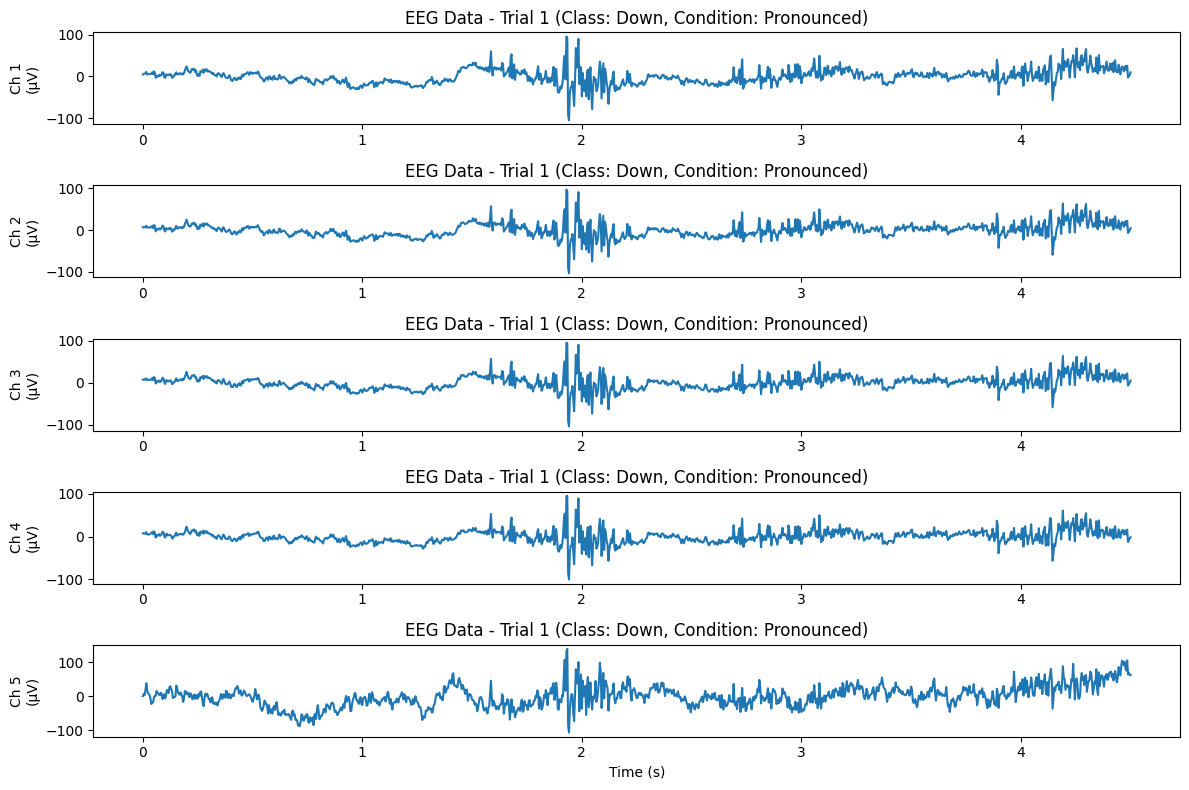

In [42]:
# Plot sample EEG data
plt.figure(figsize=(12, 8))

# Select first trial and first few channels
trial_idx = 0
channels_to_plot = 5
time_axis = np.arange(X_windowed.shape[2]) / fs

for ch in range(channels_to_plot):
    plt.subplot(channels_to_plot, 1, ch + 1)
    plt.plot(time_axis, X_windowed[trial_idx, ch, :] * 1e6)  # Convert to microvolts
    plt.ylabel(f'Ch {ch+1}\n(μV)')
    # if ch == 0:
    plt.title(f'EEG Data - Trial {trial_idx + 1} (Class: {classes[Y[trial_idx, 1]]}, Condition: {conditions[Y[trial_idx, 2]]})')
    if ch == channels_to_plot - 1:
        plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

## 8. Summary and Next Steps

In [39]:
print("=== Dataset Access Summary ===")
print(f"✓ Successfully accessed derivatives folder")
print(f"✓ Loaded preprocessed EEG data")
print(f"✓ Data shape: {X.shape} (trials × channels × samples)")
print(f"✓ Sampling frequency: {fs} Hz")
print(f"✓ Available subjects: {len(subjects)}")
print(f"✓ Sessions per subject: 3")
print(f"✓ Conditions: Pronounced, Inner Speech, Visualized")
print(f"✓ Classes: Up, Down, Right, Left")
print(f"✓ Individual trials extracted to: {extracted_data_path}")

print("\n=== Next Steps ===")
print("1. Feature extraction (e.g., spectral features, CSP)")
print("2. Machine learning classification")
print("3. Cross-validation and performance evaluation")
print("4. Multi-subject analysis")
print("5. Use extracted individual trials for custom processing")

=== Dataset Access Summary ===
✓ Successfully accessed derivatives folder
✓ Loaded preprocessed EEG data
✓ Data shape: (600, 128, 1153) (trials × channels × samples)
✓ Sampling frequency: 256 Hz
✓ Available subjects: 10
✓ Sessions per subject: 3
✓ Conditions: Pronounced, Inner Speech, Visualized
✓ Classes: Up, Down, Right, Left
✓ Individual trials extracted to: extracted_data

=== Next Steps ===
1. Feature extraction (e.g., spectral features, CSP)
2. Machine learning classification
3. Cross-validation and performance evaluation
4. Multi-subject analysis
5. Use extracted individual trials for custom processing
